## Model for Multilabel Theme Classification (Fasttext + BiGRU) 

This notebook can be used to train the main theme model for multilabel classification of comments of Question 1
<br> You can connect this notebook to a GPU/TPU from *Runtime -> Change runtime type*

#### Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Concatenate
from keras.layers import Conv1D, Conv2D, MaxPooling2D, GlobalMaxPooling1D, MaxPooling1D, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Input
from keras.layers.merge import concatenate
from keras.utils import to_categorical
from keras import layers
import tensorflow as tf
from tensorflow.keras import regularizers

Using TensorFlow backend.


In [3]:
import keras

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, hamming_loss, precision_recall_curve
import matplotlib.pyplot as plt

#### Loading the data

Using the Files tab (on the left bar), upload the following files on Collab from the **data/interim/question1_models/advance/** subdirectory of project repository:
1. embedding_matrix.npy
2. X_train_padded.npy
3. X_valid_padded.npy
4. y_train.npy
5. y_valid.npy

*Warning: Be careful while uploading files. **Do not** upload files with sensitive information.*

In [5]:
padded_docs_train = np.load('X_train_padded.npy')
padded_docs_valid = np.load('X_valid_padded.npy')
embedding_matrix_fastext = np.load('embedding_matrix.npy')
y_train_ohe = np.load('y_train.npy')
y_valid_ohe = np.load('y_valid.npy')

In [6]:
padded_docs_train.shape

(20330, 220)

In [17]:
## Mount your google drive in order to save the trained model
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Model Building

In [7]:
max_features = embedding_matrix_fastext.shape[0] ## vocabulary size
maxlen = padded_docs_train.shape[1]
embed_size = 300
n_class = 12

epochs = 12
batch_size = 100

In [8]:
def define_model(length, max_features):
  # channel 1
  inputs1 = Input(shape=(length,))
  embedding1 = Embedding(max_features, embed_size, weights=[embedding_matrix_fastext], trainable=False)(inputs1)

  bi_gru = Bidirectional(GRU(278, return_sequences=True))(embedding1)

  global_pool = GlobalMaxPooling1D()(bi_gru)
  avg_pool = GlobalAveragePooling1D()(bi_gru)

  concat_layer = Concatenate()([global_pool, avg_pool])

  output = Dense(n_class, activation='sigmoid')(concat_layer)

  model=Model(inputs1, output)

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'categorical_accuracy'])
  model.summary()
  return model

In [10]:
model_gru = define_model(maxlen, max_features)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 220)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 220, 300)     3468000     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 220, 556)     965772      embedding_2[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 556)          0           bidirectional_2[0][0]            
____________________________________________________________________________________________

In [11]:
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.fit(padded_docs_train, y_train_ohe, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1)

Train on 18297 samples, validate on 2033 samples
Epoch 1/12
18297/18297 [==============================] - 256s 14ms/step - loss: 0.2665 - accuracy: 0.9042 - val_loss: 0.1996 - val_accuracy: 0.9249
Epoch 2/12
18297/18297 [==============================] - 256s 14ms/step - loss: 0.1806 - accuracy: 0.9319 - val_loss: 0.1787 - val_accuracy: 0.9328
Epoch 3/12
18297/18297 [==============================] - 255s 14ms/step - loss: 0.1610 - accuracy: 0.9383 - val_loss: 0.1698 - val_accuracy: 0.9357
Epoch 4/12
18297/18297 [==============================] - 254s 14ms/step - loss: 0.1491 - accuracy: 0.9429 - val_loss: 0.1674 - val_accuracy: 0.9370
Epoch 5/12
18297/18297 [==============================] - 255s 14ms/step - loss: 0.1390 - accuracy: 0.9464 - val_loss: 0.1654 - val_accuracy: 0.9372
Epoch 6/12
18297/18297 [==============================] - 260s 14ms/step - loss: 0.1296 - accuracy: 0.9500 - val_loss: 0.1621 - val_accuracy: 0.9384
Epoch 7/12
18297/18297 [==============================] -

#### Prediction and Evaluation

In [12]:
pred_bidgru = model_gru.predict(padded_docs_valid)

In [ ]:
# pred_training = model_gru_4.predict(padded_docs_train)

In [13]:
# PRECISION & RECALL
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, hamming_loss, jaccard_score
predictions_results = []

thresholds=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for val in thresholds:
  pred=pred_bidgru.copy()
  pred[pred>=val]=1
  pred[pred<val]=0
  
  # pred_t=pred_training.copy()
  # pred_t[pred_t>=val]=1
  # pred_t[pred_t<val]=0

  # train_accuracy = accuracy_score(y_train_ohe, pred_t, normalize=True, sample_weight=None) 
  accuracy = accuracy_score(y_valid_ohe, pred, normalize=True, sample_weight=None)
  hamming = hamming_loss(y_valid_ohe, pred)
  precision = precision_score(y_valid_ohe, pred, average='micro')
  recall = recall_score(y_valid_ohe, pred, average='micro')
  f1 = f1_score(y_valid_ohe, pred, average='micro')
  j_score = jaccard_score(y_valid_ohe, pred, average='weighted')
  case= {'Threshold': val,
        #  'Training Accuracy': train_accuracy,
          'Accuracy': accuracy,
          'Hamming loss': hamming,
          'Precision': precision,
          'Recall': recall,
          'F1-measure': f1,
          'Jaccard Score': j_score}
  predictions_results.append(case)

print("Micro-average quality numbers:")
pd.DataFrame(predictions_results)

Micro-average quality numbers:


,Threshold,Accuracy,Hamming loss,Precision,Recall,F1-measure,Jaccard Score
0,0.3,0.496754,0.068316,0.699191,0.735360,0.716820,0.569869
1,0.4,0.519378,0.064119,0.738342,0.704267,0.720902,0.572070
2,0.5,0.524493,0.062791,0.767104,0.669130,0.714775,0.562368
3,0.6,0.524493,0.062004,0.795193,0.636642,0.707140,0.551554
4,0.7,0.517214,0.061906,0.824541,0.601506,0.695582,0.536098
5,0.8,0.498918,0.063184,0.857389,0.554936,0.673777,0.509180
6,0.9,0.461342,0.067234,0.891609,0.487451,0.630307,0.460235


*Note that the precision-recall values may change slightly each time the model is run due to randomness while fitting the model*

#### Plotting the precision-recall curve

In [22]:
precision = dict()
recall = dict()
thresh = dict()

In [23]:
precision["bigru"], recall["bigru"], thresh["bigru"] = precision_recall_curve(y_valid_ohe.ravel(), pred_bidgru.ravel())

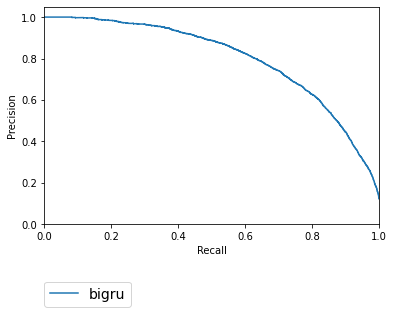

In [24]:
labels = []
labels = list(precision.keys())

plt.figure()
plt.step(recall['bigru'], precision['bigru'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(labels, loc=(0, -.38), prop=dict(size=14))

#### Loading and running MDS 2019-20 team's BiGRU + Fasttext model

To run the saved model in the repository, upload the model on Google Drive, mount the drive to this Colab notebook and run the following command (change the path according to your Drive) 

In [25]:
model_theme = keras.models.load_model('/content/gdrive/My Drive/Model_Files_Capstone/theme_model')

In [26]:
pred_model_theme = model_theme.predict(padded_docs_valid)

In [20]:
# PRECISION & RECALL
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, hamming_loss, jaccard_score
predictions_results = []

thresholds=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for val in thresholds:
  pred=pred_model_theme.copy()
  pred[pred>=val]=1
  pred[pred<val]=0
  
  # pred_t=pred_training.copy()
  # pred_t[pred_t>=val]=1
  # pred_t[pred_t<val]=0

  # train_accuracy = accuracy_score(y_train_ohe, pred_t, normalize=True, sample_weight=None) 
  accuracy = accuracy_score(y_valid_ohe, pred, normalize=True, sample_weight=None)
  hamming = hamming_loss(y_valid_ohe, pred)
  precision = precision_score(y_valid_ohe, pred, average='micro')
  recall = recall_score(y_valid_ohe, pred, average='micro')
  f1 = f1_score(y_valid_ohe, pred, average='micro')
  j_score = jaccard_score(y_valid_ohe, pred, average='weighted')
  case= {'Threshold': val,
        #  'Training Accuracy': train_accuracy,
          'Accuracy': accuracy,
          'Hamming loss': hamming,
          'Precision': precision,
          'Recall': recall,
          'F1-measure': f1,
          'Jaccard Score': j_score}
  predictions_results.append(case)

print("Micro-average quality numbers:")
pd.DataFrame(predictions_results)

Micro-average quality numbers:


,Threshold,Accuracy,Hamming loss,Precision,Recall,F1-measure,Jaccard Score
0,0.3,0.500492,0.067283,0.703502,0.739403,0.721006,0.578884
1,0.4,0.524100,0.063234,0.743643,0.705382,0.724007,0.578052
2,0.5,0.533937,0.061857,0.774157,0.669130,0.717822,0.568019
3,0.6,0.529018,0.061545,0.798985,0.636782,0.708721,0.555421
4,0.7,0.519772,0.061791,0.826897,0.600112,0.695484,0.537609
5,0.8,0.499902,0.063381,0.856865,0.553402,0.672484,0.508817
6,0.9,0.465276,0.066857,0.899329,0.485778,0.630817,0.461664
